In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re as re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")

import wandb
wandb.login(key=secret_value_0)

In [4]:
import os

data_path = "/kaggle/input/allthenews"
print(os.listdir(data_path))

['articles2.csv', 'articles3.csv', 'articles1.csv']


In [ ]:
df1 = pd.read_csv(f'{data_path}/articles1.csv')
df2 = pd.read_csv(f'{data_path}/articles2.csv')
df3 = pd.read_csv(f'{data_path}/articles3.csv')

In [8]:
dff = pd.concat([df1,df2,df3])
dff = dff[['publication', 'content']]
dff.shape

(142570, 2)

In [9]:
media_data = dff.sample(frac=1)
media_outlets = media_data['publication'].unique()

In [ ]:
media_bias = {
    "Breitbart": "Right",
    "New York Post": "Lean Right",
    "NPR": "Lean Left",
    "CNN": "Lean Left",
    "Washington Post": "Lean Left",
    "Reuters": "Center",
    "Guardian": "Left",
    "New York Times": "Lean Left",
    "Atlantic": "Left",
    "Business Insider": "Lean Left",
    "National Review": "Lean Right",
    "Talking Points Memo": "NA",
    "Vox": "Left",
    "Buzzfeed News": "NA",
    "Fox News": "Right"
}

In [11]:
for media_outlet in media_outlets:
  if media_bias[media_outlet] and media_bias[media_outlet] != "NA":
    media_data.loc[media_data['publication'] == media_outlet, 'publication'] = media_bias[media_outlet]
  else:
    media_data = media_data[media_data['publication'] != media_outlet]

media_data = media_data.rename(columns={'publication': 'bias'})
media_data['bias'].value_counts()

bias
Lean Left     49154
Right         28135
Lean Right    23696
Left          20807
Center        10710
Name: count, dtype: int64

Total words: 53023615


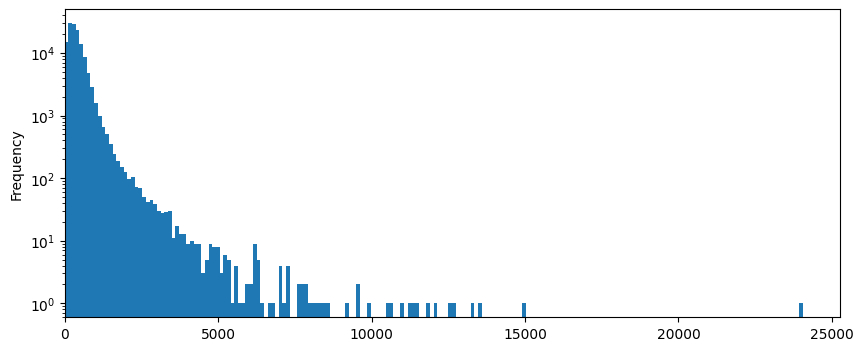

In [12]:
# 5. Data Preprocessing-1  for 'content' attribute

#Lower case, Replace publications and special charactor with empty space
import re
from sklearn.feature_extraction import text

URL_RE = re.compile(r"http\S+|www\S+")
HTML_RE = re.compile(r"<.*?>")
REPLACE_BY_SPACE_RE = re.compile(r"[/(){}\[\]\|@,;]")
BAD_SYMBOLS_RE = re.compile(r"[^0-9a-z #+_]")
STOPWORDS = text.ENGLISH_STOP_WORDS

def clean_text(text):
    text = text.lower()
    text = URL_RE.sub(' ', text)
    text = HTML_RE.sub(' ', text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub(' ', text)
    for media_outlet in media_outlets:
        text = text.replace(str(media_outlet), '')
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    return text.strip()

media_data['content'] = media_data['content'].apply(clean_text)


s = media_data['content'].str.split().str.len()
plt.figure(figsize=(10, 4))
s.plot.hist(bins=200)
plt.xlim(0)
plt.yscale('log')
print("Total words:",s.sum())

In [13]:
media_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132502 entries, 33530 to 10237
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   bias     132502 non-null  object
 1   content  132502 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB


In [15]:
# Take 20% samples for quick test
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

sample = media_data.sample(frac=0.2, random_state=42)

x_sample = sample['content']
y_sample = le.fit_transform(sample['bias'])  # use same encoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

train_X, test_X, train_Y, test_Y = train_test_split(x_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

In [16]:
vec = TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=10)
X_train = vec.fit_transform(train_X)
X_test = vec.transform(test_X)

In [17]:
#Logistic Regression
lr_classifier = LogisticRegression(max_iter=400)
lr_classifier.fit(X_train, train_Y)

lr_pred = lr_classifier.predict(X_test)

print("Accuracy:", lr_classifier.score(X_test, test_Y))
print(classification_report(test_Y, lr_pred))
print(confusion_matrix(test_Y, lr_pred))

Accuracy: 0.7554716981132076
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       426
           1       0.69      0.88      0.77      1971
           2       0.73      0.59      0.65       929
           3       0.77      0.55      0.64       853
           4       0.86      0.78      0.81      1121

    accuracy                           0.76      5300
   macro avg       0.80      0.74      0.76      5300
weighted avg       0.77      0.76      0.75      5300

[[ 387   31    5    2    1]
 [   3 1733   98   76   61]
 [   4  276  549   42   58]
 [   2  293   66  465   27]
 [   2  196   35   18  870]]


In [18]:
#Random Forest
rm_classifier = RandomForestClassifier(n_jobs=-1)
rm_classifier.fit(X_train, train_Y)

rm_pred = rm_classifier.predict(X_test)

print("Accuracy:", rm_classifier.score(X_test, test_Y))
print(classification_report(test_Y, rm_pred))
print(confusion_matrix(test_Y, rm_pred))

Accuracy: 0.6983018867924529
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       426
           1       0.58      0.96      0.72      1971
           2       0.85      0.43      0.57       929
           3       0.93      0.28      0.44       853
           4       0.87      0.69      0.77      1121

    accuracy                           0.70      5300
   macro avg       0.84      0.66      0.69      5300
weighted avg       0.78      0.70      0.68      5300

[[ 402   24    0    0    0]
 [   3 1892   21   10   45]
 [   0  489  395    7   38]
 [   0  561   20  243   29]
 [   1  320   29    2  769]]


In [19]:
#Extra Trees
et_classifier = ExtraTreesClassifier(n_jobs=-1)
et_classifier.fit(X_train, train_Y)

et_pred = et_classifier.predict(X_test)

print("Accuracy:", et_classifier.score(X_test, test_Y))
print(classification_report(test_Y, et_pred))
print(confusion_matrix(test_Y, et_pred))

Accuracy: 0.6981132075471698
              precision    recall  f1-score   support

           0       1.00      0.96      0.97       426
           1       0.56      0.98      0.71      1971
           2       0.92      0.41      0.56       929
           3       0.96      0.28      0.43       853
           4       0.95      0.66      0.78      1121

    accuracy                           0.70      5300
   macro avg       0.88      0.66      0.69      5300
weighted avg       0.80      0.70      0.68      5300

[[ 407   19    0    0    0]
 [   2 1936    9    6   18]
 [   0  540  377    2   10]
 [   0  595   10  239    9]
 [   0  362   16    2  741]]


In [20]:
#LinearSVC
svc_classifier = LinearSVC()
svc_classifier.fit(X_train, train_Y)

svc_pred = svc_classifier.predict(X_test)

print("Accuracy:", svc_classifier.score(X_test, test_Y))
print(classification_report(test_Y, svc_pred))
print(confusion_matrix(test_Y, svc_pred))

Accuracy: 0.7756603773584906
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       426
           1       0.75      0.83      0.79      1971
           2       0.70      0.68      0.69       929
           3       0.71      0.62      0.67       853
           4       0.86      0.80      0.83      1121

    accuracy                           0.78      5300
   macro avg       0.80      0.78      0.79      5300
weighted avg       0.78      0.78      0.77      5300

[[ 409   12    3    2    0]
 [   3 1643  140  120   65]
 [   2  194  628   54   51]
 [   3  213   74  533   30]
 [   2  134   50   37  898]]


In [21]:
#AdaBoost
ab_classifier = AdaBoostClassifier()
ab_classifier.fit(X_train, train_Y)

ab_pred = ab_classifier.predict(X_test)

print("Accuracy:", ab_classifier.score(X_test, test_Y))
print(classification_report(test_Y, ab_pred))
print(confusion_matrix(test_Y, ab_pred))

Accuracy: 0.5328301886792453
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       426
           1       0.46      0.88      0.61      1971
           2       0.30      0.13      0.18       929
           3       0.27      0.02      0.04       853
           4       0.79      0.49      0.61      1121

    accuracy                           0.53      5300
   macro avg       0.56      0.49      0.48      5300
weighted avg       0.52      0.53      0.47      5300

[[ 401   25    0    0    0]
 [   4 1731  144   32   60]
 [   0  767  120   16   26]
 [   0  685   87   20   61]
 [   1  520   43    5  552]]


In [22]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), device="cuda", n_estimators=400,)
xgb_classifier.fit(X_train, train_Y)

xgb_pred = xgb_classifier.predict(X_test)

print("Accuracy:", xgb_classifier.score(X_test, test_Y))
print(classification_report(test_Y, xgb_pred))
print(confusion_matrix(test_Y, xgb_pred))

Accuracy: 0.3739622641509434
              precision    recall  f1-score   support

           0       0.36      0.10      0.15       426
           1       0.39      0.79      0.53      1971
           2       0.23      0.15      0.18       929
           3       0.50      0.00      0.01       853
           4       0.38      0.21      0.27      1121

    accuracy                           0.37      5300
   macro avg       0.37      0.25      0.23      5300
weighted avg       0.38      0.37      0.30      5300

[[  41  263   15    0  107]
 [  31 1566  212    1  161]
 [   9  722  141    1   56]
 [   6  704   90    4   49]
 [  26  721  142    2  230]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:57:30] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [23]:
#Multinomial Naive Bayes
mnb_classifier = MultinomialNB()
mnb_classifier.fit(X_train, train_Y)

mnb_pred = mnb_classifier.predict(X_test)

print("Accuracy:", mnb_classifier.score(X_test, test_Y))
print(classification_report(test_Y, mnb_pred))
print(confusion_matrix(test_Y, mnb_pred))

Accuracy: 0.6135849056603774
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       426
           1       0.51      0.94      0.66      1971
           2       0.81      0.23      0.36       929
           3       0.78      0.21      0.33       853
           4       0.82      0.61      0.70      1121

    accuracy                           0.61      5300
   macro avg       0.76      0.55      0.58      5300
weighted avg       0.70      0.61      0.58      5300

[[ 328   90    1    0    7]
 [  15 1846   24   16   70]
 [  14  621  217   24   53]
 [   5  633   17  177   21]
 [   4  415    9    9  684]]


In [24]:
# 8. Data Preprocessing-2  for 'content' attribute

# out of vacbulary token to handle unseen words
# Don’t use the full vocabulary. Many rare words add noise. Limit to top N words
tokenizer = Tokenizer(num_words=30000, oov_token="<OOV>")
tokenizer.fit_on_texts(media_data['content'])
X_train_dnn = tokenizer.texts_to_sequences(train_X)
X_test_dnn = tokenizer.texts_to_sequences(test_X)

vocab_size = len(tokenizer.word_index) + 1

max_len = 800

#padding to make the input size consistent
X_train_final = pad_sequences(X_train_dnn, padding='post', maxlen=max_len)
X_test_final = pad_sequences(X_test_dnn, padding='post', maxlen=max_len)

print("Vocab Size: ",vocab_size)

Vocab Size:  291267


In [25]:
# 9. Creating DNN model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout

embedding_dim = 128

# Model design
model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.build(input_shape=(None, max_len))
model.summary()

I0000 00:00:1763121480.285763      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13860 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763121480.286416      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 800, 128)       │    37,282,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 800, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,389,573 (142.63 MB)

 Trainable params: 37,389,573 (142.63 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# 11. Model fitting
model_data = model.fit(X_train_final, train_Y, validation_split=0.20, epochs=3, batch_size=64)

Epoch 1/3


I0000 00:00:1763121485.079526     179 cuda_dnn.cc:529] Loaded cuDNN version 90300


265/265 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.4377 - loss: 1.3315 - val_accuracy: 0.6967 - val_loss: 0.7425
Epoch 2/3
265/265 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.7841 - loss: 0.5806 - val_accuracy: 0.7686 - val_loss: 0.6000
Epoch 3/3
265/265 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.9267 - loss: 0.2366 - val_accuracy: 0.7545 - val_loss: 0.6935


In [27]:
# 12. Model prediction with scores
score = model.evaluate(X_test_final, test_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7017313838005066
Test accuracy: 0.7592452764511108


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

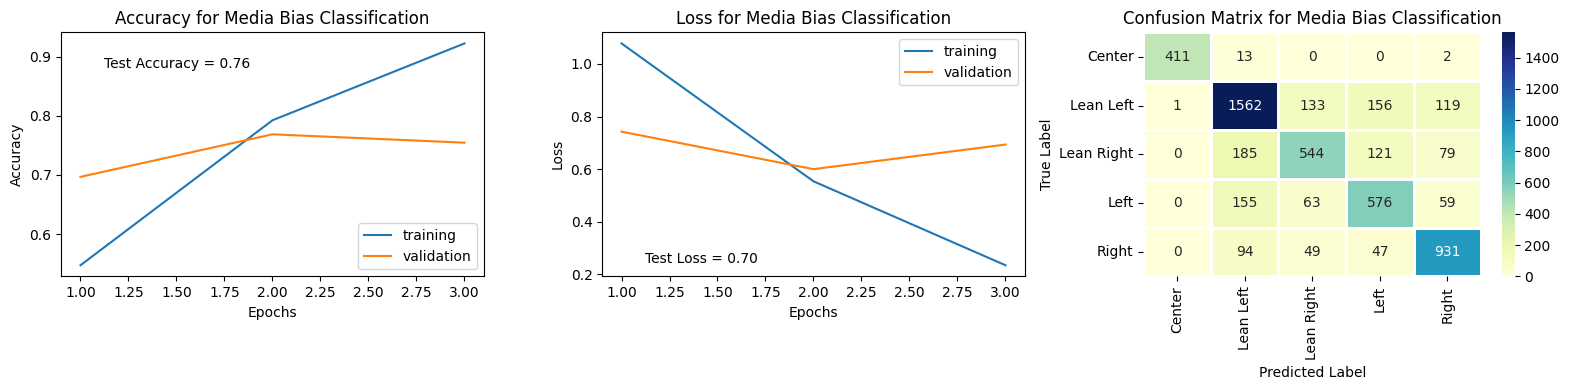

In [28]:
# 13. Visualization

import seaborn as sns
from sklearn.metrics import confusion_matrix

epochs = np.arange(1, len(model_data.history['accuracy']) + 1)
y_pred_probabilities = model.predict(X_test_final)
y_pred = np.argmax(y_pred_probabilities, axis=1)
class_names = le.inverse_transform(np.arange(len(le.classes_)))

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

with sns.color_palette("Accent", n_colors=8):
    sns.lineplot(x=epochs, y=model_data.history['accuracy'], ax=axes[0], label='training')
    sns.lineplot(x=epochs, y=model_data.history['val_accuracy'], ax=axes[0], label='validation')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy for Media Bias Classification")
axes[0].legend(loc='lower right')
axes[0].text(0.1, 0.9, f'Test Accuracy = {score[1]:.2f}',
            transform=axes[0].transAxes, ha='left', va='top')

with sns.color_palette("Accent", n_colors=8):
    sns.lineplot(x=epochs, y=model_data.history['loss'], ax=axes[1], label='training')
    sns.lineplot(x=epochs, y=model_data.history['val_loss'], ax=axes[1], label='validation')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss for Media Bias Classification")
axes[1].legend(loc='upper right')
axes[1].text(0.1, 0.1, f'Test Loss = {score[0]:.2f}',
            transform=axes[1].transAxes, ha='left', va='top')

sns.heatmap(confusion_matrix(test_Y, y_pred),
            annot=True, linewidths=2, cmap="YlGnBu", fmt="g",
            xticklabels=class_names, yticklabels=class_names, ax=axes[2])
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')
axes[2].set_title("Confusion Matrix for Media Bias Classification")

fig.tight_layout()
plt.show()

In [29]:
# 10. Creating CNN Model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout

# CNN Model design
cnn_model = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

cnn_model.build(input_shape=(None, max_len))
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 800, 128)       │    37,282,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 796, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,372,805 (142.57 MB)

 Trainable params: 37,372,805 (142.57 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# 11. Model fitting

cnn_model_data = cnn_model.fit(X_train_final, train_Y, validation_split=0.20, epochs=3, batch_size=32)

Epoch 1/3


I0000 00:00:1763121559.934799     178 service.cc:148] XLA service 0x7f22b4029e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763121559.935631     178 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763121559.935648     178 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  9/530 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1450 - loss: 1.6077

I0000 00:00:1763121562.415087     178 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


530/530 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.4896 - loss: 1.2096 - val_accuracy: 0.7191 - val_loss: 0.6744
Epoch 2/3
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8354 - loss: 0.4594 - val_accuracy: 0.7809 - val_loss: 0.5648
Epoch 3/3
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9854 - loss: 0.0779 - val_accuracy: 0.7599 - val_loss: 0.7377


In [31]:
# 12. Model prediction with scores

cnn_score = cnn_model.evaluate(X_test_final, test_Y, verbose=0)
print('Test loss:', cnn_score[0])
print('Test accuracy:', cnn_score[1])

Test loss: 0.6883534789085388
Test accuracy: 0.7698113322257996


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

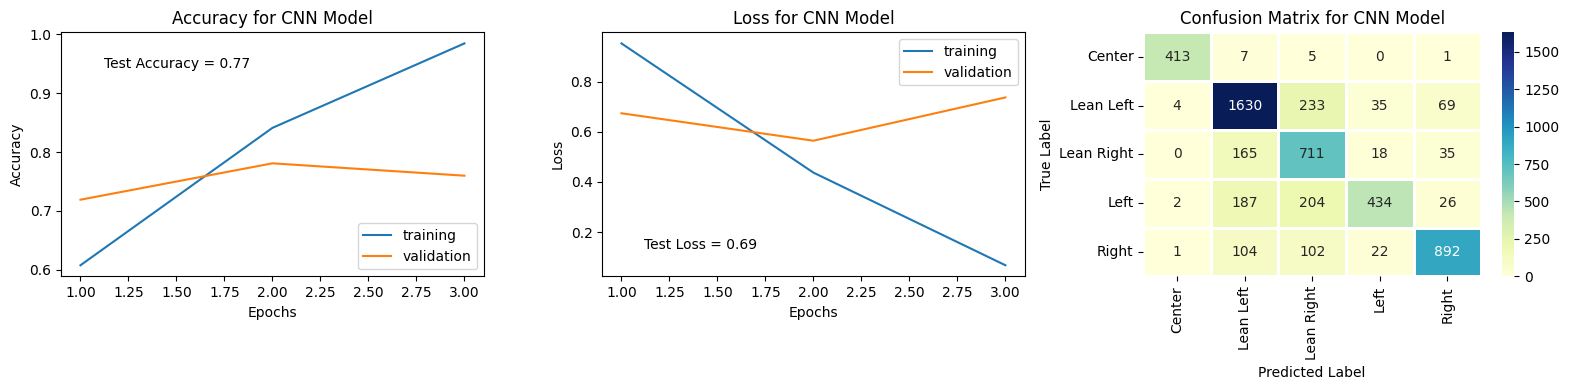

In [36]:
# 13. Visualization

import seaborn as sns
from sklearn.metrics import confusion_matrix

epochs = np.arange(1, len(cnn_model_data.history['accuracy']) + 1)
cnn_y_pred_probabilities = cnn_model.predict(X_test_final)
cnn_y_pred = np.argmax(cnn_y_pred_probabilities, axis=1)
class_names = le.inverse_transform(np.arange(len(le.classes_)))

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

with sns.color_palette("Accent", n_colors=8):
    sns.lineplot(x=epochs, y=cnn_model_data.history['accuracy'], ax=axes[0], label='training')
    sns.lineplot(x=epochs, y=cnn_model_data.history['val_accuracy'], ax=axes[0], label='validation')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy for CNN Model")
axes[0].legend(loc='lower right')
axes[0].text(0.1, 0.9, f'Test Accuracy = {cnn_score[1]:.2f}',
            transform=axes[0].transAxes, ha='left', va='top')

with sns.color_palette("Accent", n_colors=8):
    sns.lineplot(x=epochs, y=cnn_model_data.history['loss'], ax=axes[1], label='training')
    sns.lineplot(x=epochs, y=cnn_model_data.history['val_loss'], ax=axes[1], label='validation')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss for CNN Model")
axes[1].legend(loc='upper right')
axes[1].text(0.1, 0.1, f'Test Loss = {cnn_score[0]:.2f}',
            transform=axes[1].transAxes, ha='left', va='bottom')

sns.heatmap(confusion_matrix(test_Y, cnn_y_pred),
            annot=True, linewidths=2, cmap="YlGnBu", fmt="g",
            xticklabels=class_names,
            yticklabels=class_names,
            ax=axes[2])
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')
axes[2].set_title("Confusion Matrix for CNN Model")

fig.tight_layout()
plt.show()


In [ ]:
from transformers import DistilBertTokenizerFast
from datasets import Dataset
import multiprocessing

# CPU cores for parallelism
NUM_CORES = multiprocessing.cpu_count()

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_dict({"text": train_X.tolist(), "label": train_Y.tolist()})
test_dataset = Dataset.from_dict({"text": test_X.tolist(), "label": test_Y.tolist()})

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Fast batch tokenization
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512  # adjust if texts are long
    )

# Apply tokenization in parallel
train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=NUM_CORES)
test_dataset = test_dataset.map(tokenize_function, batched=True, num_proc=NUM_CORES)

# Format for TensorFlow
train_dataset.set_format(type="tf", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="tf", columns=["input_ids", "attention_mask", "label"])

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Training setup
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # you can add metrics if needed
)

# Train
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_48/368350009.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.676300,0.617321,0.767547,0.772701,0.767547,0.765311
2,0.484200,0.520272,0.805094,0.807154,0.805094,0.803321
3,0.397400,0.507044,0.817925,0.816901,0.817925,0.816776


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1989, training_loss=0.6072177378720168, metrics={'train_runtime': 1939.3593, 'train_samples_per_second': 32.794, 'train_steps_per_second': 1.026, 'total_flos': 8425377294336000.0, 'train_loss': 0.6072177378720168, 'epoch': 3.0})

In [ ]:
# Evaluate

eval_results = trainer.evaluate()
distilbert_accuracy = eval_results['eval_accuracy']

print(eval_results)
print(f"DistilBERT Accuracy: {distilbert_accuracy}")

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.5070436000823975, 'eval_accuracy': 0.8179245283018868, 'eval_precision': 0.816900681622155, 'eval_recall': 0.8179245283018868, 'eval_f1': 0.8167761878389409, 'eval_runtime': 53.0645, 'eval_samples_per_second': 99.878, 'eval_steps_per_second': 3.128, 'epoch': 3.0}
DistilBERT Accuracy: 0.8179245283018868


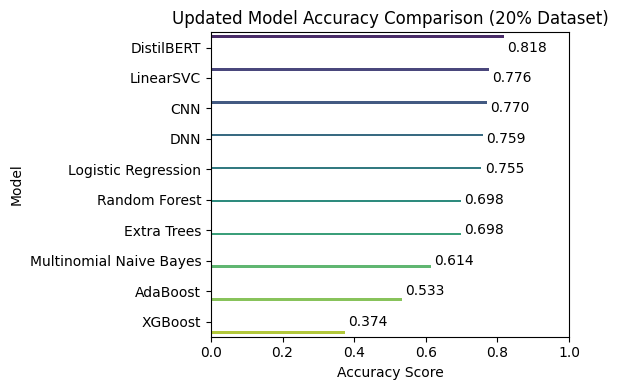

In [ ]:
# 13. Visualization and Model Comparison

model_names = [
    "Logistic Regression",
    "Random Forest",
    "Extra Trees",
    "LinearSVC",
    "AdaBoost",
    "XGBoost",
    "Multinomial Naive Bayes",
    "DNN",
    "CNN",
    "DistilBERT"
]

# X_test_for_sklearn was already created using tfidf_transformer.transform(vectorizer.transform(test_X))
accuracy_scores = [
    lr_classifier.score(X_test, test_Y),
    rm_classifier.score(X_test, test_Y),
    et_classifier.score(X_test, test_Y),
    svc_classifier.score(X_test, test_Y),
    ab_classifier.score(X_test, test_Y),
    xgb_classifier.score(X_test, test_Y),
    mnb_classifier.score(X_test, test_Y),
    score[1], # DNN accuracy
    cnn_score[1], # CNN accuracy
    distilbert_accuracy
]

# Create a DataFrame for easy plotting
comparison_df_updated = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_scores
})

# Sort by accuracy for better visualization
comparison_df_updated = comparison_df_updated.sort_values(by='Accuracy', ascending=False)

# Create the bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x='Accuracy', y='Model', hue='Model', data=comparison_df_updated, palette='viridis')
plt.legend().remove()
plt.title('Updated Model Accuracy Comparison (20% Dataset)')
plt.xlabel('Accuracy Score')
plt.ylabel('Model')
plt.xlim(0, 1) # Set x-axis limit from 0 to 1 for accuracy

# Add accuracy values on the bars, using enumerate for correct y-position
for i, (index, row) in enumerate(comparison_df_updated.iterrows()):
    plt.text(row.Accuracy + 0.01, i, f'{row.Accuracy:.3f}', color='black', ha="left", va="center")

plt.tight_layout()
plt.show()